In [2]:
%load_ext autoreload
import pickle
import sys
sys.path.append('../../..')
import numpy as np
from scipy.interpolate import interp1d
from tqdm import tqdm_notebook as tqdm

import config
import main
import darkhistory.physics as phys
import darkhistory.history.tla as tla
import darkhistory.low_energy.atomic as atomic
import darkhistory.low_energy.bound_free as bf
from plotting_utils import plot_distortion, download_plot

import matplotlib
matplotlib.rc_file('../../../matplotlibrc')
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import matplotlib.colors as colors
%matplotlib inline

hplanck = phys.hbar * 2 * np.pi

dir_str = '/Users/viviesque/Dropbox (MIT)/DarkHistory_V2/data/HL_diff_nmax_iter_5_std/'
fig_dir = '/Users/viviesque/OneDrive - Massachusetts Institute of Technology/DarkHistory/figs/'

Rather than use fitting functions with fudge factors for the recombination and photo-ionization coefficients, $\alpha_B$ and $\beta_B$, we now calculate them.  To test if we have done so correctly we calculate $x_e(z)$ and compare to the solid line in Fig. 3 of [1011.3758](https://arxiv.org/pdf/1011.3758.pdf), Hyrec's paper.

In [3]:
# Download Hyrec plots
EMLA_data = download_plot('/EMLA', config.data_path)
Rec_data = download_plot('/Recfast', config.data_path)

In [12]:
nmax_conv = {}
nmax_conv['10'] = pickle.load(open(dir_str+'log10mDM_8.0000_phot_decay_log10param_40.0000_std_distort_nmax_10_no_reion_ind_0.p', 'rb'))
nmax_conv['20'] = pickle.load(open(dir_str+'log10mDM_8.0000_phot_decay_log10param_40.0000_std_distort_nmax_20_no_reion_ind_0.p', 'rb'))
nmax_conv['50'] = pickle.load(open(dir_str+'log10mDM_8.0000_phot_decay_log10param_40.0000_std_distort_nmax_50_no_reion_ind_0.p', 'rb'))
nmax_conv['100'] = pickle.load(open(dir_str+'log10mDM_8.0000_phot_decay_log10param_40.0000_std_distort_nmax_100_no_reion_ind_0.p', 'rb'))
nmax_conv['200'] = pickle.load(open(dir_str+'log10mDM_8.0000_phot_decay_log10param_40.0000_std_distort_nmax_200_no_reion_ind_0.p', 'rb'))

In [13]:
eng = np.exp(np.linspace(
    np.log(hplanck*1e8), np.log(phys.rydberg), 500))

rs_list = nmax_conv['10']['data'][-1]['rs']

baseline = tla.get_history(rs_list, high_rs=1.555e3,
                           fudge=1.0, gauss_fudge=False, rtol=1e-8)
fudge_1_14 = tla.get_history(rs_list, high_rs=1.555e3,
                             fudge=1.14, gauss_fudge=False, rtol=1e-8)

dist_eng = np.exp(np.linspace(np.log(hplanck*1e8), np.log(phys.rydberg), 10))

nmax_list = [10,20,50,100,200]#,300]

In [14]:
# %autoreload
# nmax_convergence_alt = {}
# for nmax in nmax_list:
#     R = atomic.populate_radial(nmax)
#     Thetas = bf.populate_thetas(nmax)

#     MLA_data = np.zeros((rs_list.size, 3))
#     for i, rs in enumerate(tqdm(rs_list)):

#         MLA_data[i], _ = atomic.process_MLA(
#             rs, 1, phys.x_std(rs, 'HI'), 
#             phys.Tm_std(rs), nmax, eng, R, Thetas
#         )

#     MLA_funcs = [interp1d(rs_list, MLA_data[:,i], fill_value='extrapolate')
#                  for i in range(3)]

#     nmax_convergence_alt[nmax] = tla.get_history(
#         rs_list, high_rs=1.555e3,
#         recfast_TLA=False, MLA_funcs=MLA_funcs,
#         rtol=1e-8
#     )
#     pickle.dump(nmax_convergence_alt, open(output_dir+'nmax_convergence.dat', 'wb'))

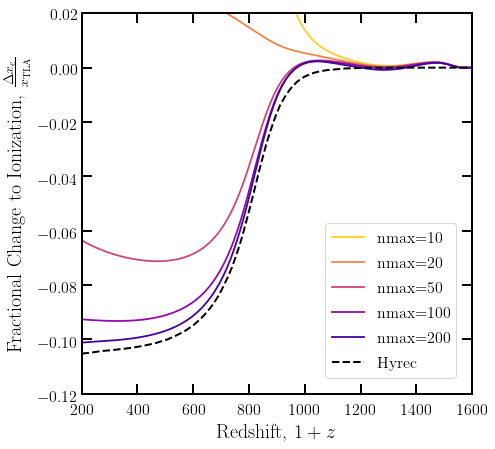

In [15]:
%autoreload
plt.figure(figsize=(7,7))
plt.axis([200,1600, -.12,.02])
ax = plt.gca()

cmap = cm.plasma(np.linspace(0.9,.1,5))

for i, nmax in enumerate(nmax_conv.keys()):
    ax.plot(rs_list, (nmax_conv[nmax]['data'][-1]['x'][:,0]+nmax_conv[nmax]['data'][-1]['x'][:,1])/baseline[:,1]-1, 
            linewidth = 1.8, label=r'nmax='+str(nmax), c=cmap[i])

# hyrec plots
lw = 1.2
ax.plot(EMLA_data[:,0], EMLA_data[:,1], color='black', 
         linewidth = 2.0, linestyle = '--', 
         label=r'Hyrec')
# ax.plot(Rec_data[:,0], Rec_data[:,1], color='gray', 
#          linewidth = 2.0, linestyle = ':', 
#          label=r'Recfast')

# plot labels
ax.set_xlabel(r'Redshift, $1+z$', fontsize=20)
ax.set_ylabel(r'Fractional Change to Ionization, $\frac{\Delta x_e}{x_{\mathrm{TLA}}}$', fontsize=20)
ax.legend(loc='lower right')

#plt.savefig(fig_dir+'Hyrec_xe_crosscheck.pdf')
plt.show()

# Directly compare ionization history to output of Hyrec/CLASS

In [19]:
filename = 'log10mDM_8.0000_phot_decay_log10param_40.0000_std_distort_nmax_200_no_reion_ind_0.p'
result = pickle.load(open(dir_str+filename, 'rb'))

In [20]:
# Load CLASS ionization history
rs_list = np.exp(np.arange(np.log(2e3), 5., -.001*4))
xe_list = np.loadtxt('/Users/viviesque/Documents/Codes/CLASS/output/CLASS_xe.csv', delimiter=',')

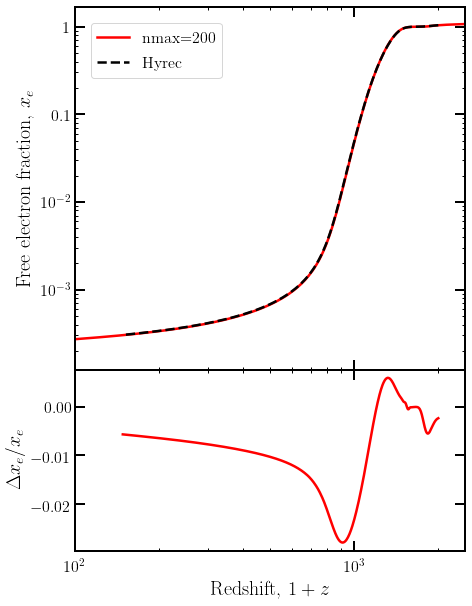

In [21]:
Hyrec_interp = interp1d(rs_list, xe_list, kind='cubic')
DH_interp = interp1d(result['data'][-1]['rs'], result['data'][-1]['x'][:,0] + result['data'][-1]['x'][:,1], kind='cubic')

fig, axs = plt.subplots(2, figsize=(7,10), sharex=True, gridspec_kw={'height_ratios': [2,1]})
marksize = 10

axs[0].loglog()
axs[0].plot(result['data'][-1]['rs'], result['data'][-1]['x'][:,0]+result['data'][-1]['x'][:,1], 
            color='r', label='nmax=200')
axs[0].plot(rs_list, xe_list, 
            color='k', linestyle='--', label='Hyrec')

axs[1].plot(rs_list, (DH_interp(rs_list) - xe_list) / xe_list, color='r')

axs[0].set_xlim(100,2500)
axs[1].set_xlabel(r'Redshift, $1+z$', fontsize=20)
axs[0].set_ylabel(r'Free electron fraction, $x_e$', fontsize=20)
axs[1].set_ylabel(r'$\Delta x_e / x_e$', fontsize=20)
axs[0].legend()

plt.subplots_adjust(hspace=0)
#plt.savefig(fig_dir+'Hyrec_xe_comparison.pdf')

# Combined plots

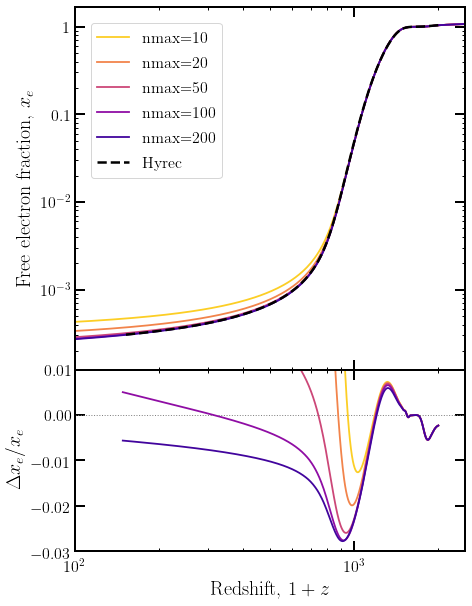

In [29]:
Hyrec_interp = interp1d(rs_list, xe_list, kind='cubic')
cmap = cm.plasma(np.linspace(0.9,.1,5))

fig, axs = plt.subplots(2, figsize=(7,10), sharex=True, gridspec_kw={'height_ratios': [2,1]})
axs[0].loglog()

for i, nmax in enumerate(nmax_conv.keys()):
    axs[0].plot(nmax_conv[nmax]['data'][-1]['rs'], (nmax_conv[nmax]['data'][-1]['x'][:,0]+nmax_conv[nmax]['data'][-1]['x'][:,1]), 
            linewidth = 1.8, label=r'nmax='+str(nmax), c=cmap[i])
    DH_interp = interp1d(nmax_conv[nmax]['data'][-1]['rs'], nmax_conv[nmax]['data'][-1]['x'][:,0]+nmax_conv[nmax]['data'][-1]['x'][:,1], kind='cubic')
    axs[1].plot(rs_list, DH_interp(rs_list)/xe_list - 1, 
            linewidth = 1.8, label=r'nmax='+str(nmax), c=cmap[i])
axs[0].plot(rs_list, xe_list, 
            color='k', linestyle='--', label='Hyrec')
axs[1].hlines(0,100,2500, linewidth=1, color='gray', linestyle=':')

axs[0].set_xlim(100,2500)
axs[1].set_ylim(-0.03,0.01)
axs[1].set_xlabel(r'Redshift, $1+z$', fontsize=20)
axs[0].set_ylabel(r'Free electron fraction, $x_e$', fontsize=20)
axs[1].set_ylabel(r'$\Delta x_e / x_e$', fontsize=20)
axs[0].legend()

plt.subplots_adjust(hspace=0)
plt.savefig(fig_dir+'Hyrec_xe_comparison.pdf')